<a href="https://colab.research.google.com/github/auphong2707/emotion-dectection-from-text/blob/decision-tree-and-random-forest/EDFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The project aims to create a **Machine Learning** powered model which is capable of classifying the emotions of the text (in the form of short quotes/comments) with predefined labels of emotions.

Emotion detection, also known as sentiment analysis, is now one of the most attractive subfields of Machine Learning, especially Natural Language Processing (NLP) due to its wide applications in many aspects of modern life, such as providing emotional information to help people developing insights or making decisions. In this project, we specifically try to convey the main emotion of a comment sentence. Generally, we expect the model to be able to take the input sentence in the form of short comments and returns its major emotion(s), corresponding to one of the predefined labels.

Our approach to solving this problem is to split it into two halves:

  1.   Data Preprocessing
  2.   Model training and Result

For detail of each half, please go into the section


The dataset we use in this project is obtained from Kaggle: [EDFT Dataset](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)

Connect to Google Drive

# **Data Preprocessing**

## Importation & Data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preparing necessary packages (may need to add more):

In [3]:
import numpy as np  # Work with multi-dimenional data
import pandas as pd # Work with relational data
import matplotlib.pyplot as plt # Visualize data
import seaborn as sns # Visualize data base on matplotlib

import warnings
warnings.filterwarnings("ignore")
# Because I hate seeing stupid warnings~

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
# Used for automatic feature extraction
from sklearn.pipeline import Pipeline
# Used for automating processes
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
# Used for spliting test and tuning hyperparameter
from sklearn.model_selection import StratifiedShuffleSplit
# Used for k-fold validiator in multi-classficiation

from sklearn.neighbors import KNeighborsClassifier
# Defining kNN
from sklearn.tree import DecisionTreeClassifier
# Defining Decision Tree
from sklearn.ensemble import RandomForestClassifier
# Defining Random Forest
from sklearn.svm import SVC
# Defining Classifier SVM
from sklearn.naive_bayes import MultinomialNB, GaussianNB
# Defining Naive Bayes

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# Used for calculating metric-related scores of the model performance, and plotting the confusion matrix

%matplotlib inline

Load data from files

In [4]:
%cd /content/drive/MyDrive/EDFT_data/

# This method use to extract all the file in the input list
def extract_data(files):
  data_x_raw = list()
  data_y_raw = list()
  for file in files:
    with open(file) as f:
      for line in f:
        line = line.strip('\n')
        x_raw, y_raw = line.split(sep=';')

        data_x_raw.append(x_raw)
        data_y_raw.append(y_raw)

  return data_x_raw, data_y_raw

# Get all data
X_train_raw, y_train_raw = extract_data(['train.txt', 'val.txt'])
X_test_raw, y_test_raw = extract_data(['test.txt'])

print("Traning data's size is:", len(X_train_raw))
print("Test data's size is:", len(X_test_raw))

/content/drive/MyDrive/EDFT_data
Traning data's size is: 18000
Test data's size is: 2000


## Feature Extraction


Removing the stopword (stop word list given at https://countwordsfree.com/stopwords)


In [5]:
file = open("stop_words_english.txt", 'r')
stopword_list = file.read().split('\n')
file.close()

# Due to the fact that the word "feel" takes too much space...
stopword_list.append("feel")
stopword_list.append("feeling")
stopword_list.append("time")
stopword_list.append("bit")
stopword_list.append("ive")
stopword_list.append("im")

Vectorize the data:

1.   Bag Of Words model (https://en.wikipedia.org/wiki/Bag-of-words_model)
2.   BoW/TF-IDF model (https://en.wikipedia.org/wiki/Tf%E2%80%93idf)



In [6]:
# Scikit CountVectorizer:
# Documentation: (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

count_vector = CountVectorizer(stop_words=stopword_list, ngram_range=(1, 2))
count_vector.fit(X_train_raw, X_test_raw)
X_train_bow = count_vector.transform(X_train_raw)
X_test_bow = count_vector.transform(X_test_raw)
dictionary = count_vector.get_feature_names_out()

print("Shape of preprocessed training data X using BoW model is: ", X_train_bow.shape)

Shape of preprocessed training data X using BoW model is:  (18000, 91542)


In [7]:
# Scikit TF-IDF:
# Documentation: (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)

tfidf_vector = TfidfVectorizer(stop_words=stopword_list, ngram_range=(1, 2))
tfidf_vector.fit(X_train_raw, X_test_raw)
X_train_tfidf = tfidf_vector.transform(X_train_raw)
X_test_tfidf = tfidf_vector.transform(X_test_raw)

print("Shape of preprocessed training data X using BoW/TF-IDF model is: ", X_train_tfidf.shape)

Shape of preprocessed training data X using BoW/TF-IDF model is:  (18000, 91542)


Cast output list to ndarray

In [8]:
y_train = np.asarray(y_train_raw)
print("Preprocessed training data y is:", y_train)
y_test = np.asarray(y_test_raw)

Preprocessed training data y is: ['sadness' 'sadness' 'anger' ... 'joy' 'joy' 'joy']


*Luckily we're quite done with the abbreviations!*

Another way: Using Word2Vec to capture the semantics
(Um, we'd talk about that later, ok?)


## Exploratory Data Analysis (EDA)

Average length of the comment:

In [ ]:
# Calculate average number of characters
sum_of_chars = sum([len(x) for x in X_train_raw])
mean_number_chars = sum_of_chars / len(X_train_raw)

# Calculate average number of words
sum_of_words = sum([len(x.split()) for x in X_train_raw])
mean_number_words = sum_of_words / len(X_train_raw)

# Print
print('The mean number of characters of each line is: %d' % mean_number_chars)
print('The mean number of words of each line is: %d' % mean_number_words)

The mean number of characters of each line is: 96
The mean number of words of each line is: 19


Statistic of output labels:

Number of labels is: 6
Labels: anger, fear, joy, love, sadness, surprise

----------------------------------------------------------------------------



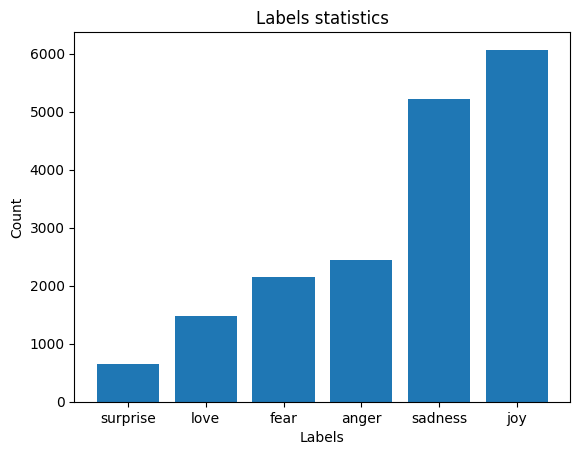

In [ ]:
# Number of labels:
labels = np.unique(y_train)
print('Number of labels is: %d' % len(labels))
print('Labels: ' + ', '.join(labels))
print('\n----------------------------------------------------------------------------\n')

# Plot:
df = pd.DataFrame(
  dict(
    labels = labels,
    label_elements_count = [y_train_raw.count(label) for label in labels]
  )
)
df = df.sort_values('label_elements_count')

plt.title(label='Labels statistics')
plt.xlabel('Labels')
plt.ylabel('Count')

plt.bar('labels', 'label_elements_count', data=df)

plt.show()

Statistics of words with the highest frequency of each label:

In [ ]:
vect_arr = X_train_bow.toarray()
vect_aggr = np.zeros(shape=(len(labels), vect_arr.shape[1]))

for idx in range(len(vect_arr)):
  label_idx = int(np.where(labels==y_train[idx])[0][0])

  vect_aggr[label_idx] += vect_arr[idx]

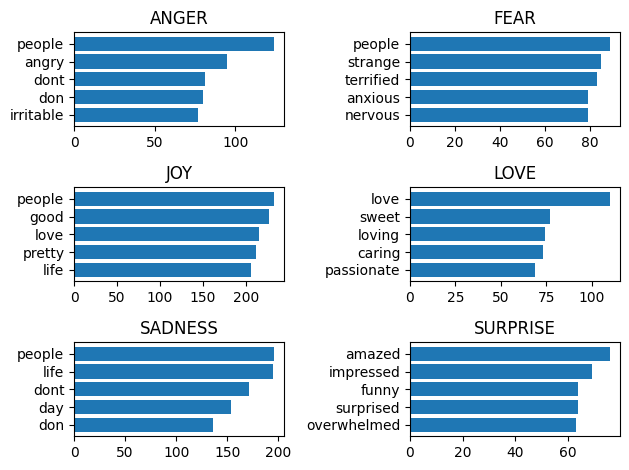

In [ ]:
fig, axs = plt.subplots(3, 2)

for label_idx in range(len(labels)):
  axs_x, axs_y = label_idx // 2, label_idx % 2

  plt_ref = axs[axs_x][axs_y]
  plt_ref.set_title(labels[label_idx].upper())

  x_axis, y_axis = list(), list()
  n_argmax = np.argpartition(vect_aggr[label_idx], -5)[-5:]
  n_argmax = n_argmax[np.argsort(vect_aggr[label_idx][n_argmax])]
  for i in n_argmax:
    x_axis.append(dictionary[i])
    y_axis.append(vect_aggr[label_idx][i])

  x_axis = np.asarray(x_axis)
  y_axis = np.asarray(y_axis)

  plt_ref.barh(x_axis, y_axis)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Variables summary




---


**X_train_raw**, **y_train_raw**: ***list***

Raw training data which is extracted directly from files.

---


**X_test*, **y_test*: ***list***

  Raw testing data which is extracted directly from files.

---


**stopword_list**: ***list***

 List of stop words used in BoW and BoW/TF-IDF models

---


**dictionary**: ***numpy.ndarray***

 Dictionary of words which is used to vectorized the data and number of occurences.

---


**X_train_bow**: ***scipy.sparse._csr.csr_matrix***

 Trainning data input which is vectorized by the BoW model.

---


**X_train_tfidf**: ***scipy.sparse._csr.csr_matrix***

 Training data input which is vectorized by the BoW/TFIDF model

---


**y_train**: ***numpy.ndarray***

 Preprocessed traning data output


---

# **Model training and result**

##General

We train some models from simple to complex:


*   K-nearest neighbors (KNN)
*   Naive Bayes Classification
*   K-means clusters
*   Neural network









## K-nearest neighbors (KNN)

We define the model first

Running a single instance just for testing!

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
dt_model = DecisionTreeClassifier()
knn_model.fit(X_train_bow, y_train)

KNeighborsClassifier(n_neighbors=3)

Getting prediction on training set (without cross validation)

In [ ]:
data_pred_y = knn_model.predict(X_train_bow)

Then evaluate it!

Accuracy score on training: 0.89
F1 score on training: 0.89


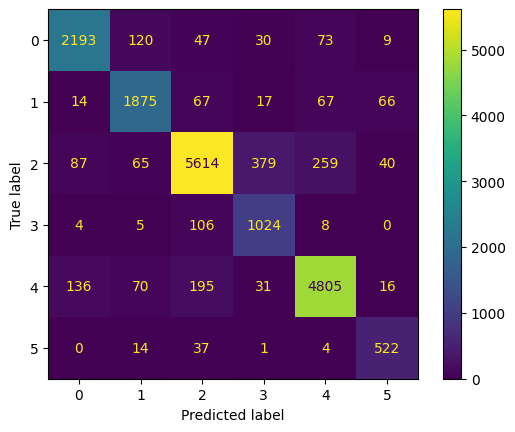

In [ ]:
print("Accuracy score on training: {:.2f}".format(accuracy_score(data_pred_y, y_train)))
print("F1 score on training: {:.2f}".format(f1_score(data_pred_y, y_train, average = 'micro')))
cm = confusion_matrix(data_pred_y, y_train)
ConfusionMatrixDisplay(cm).plot()

Accuracy score on testing: 0.77
F1 score on testing: 0.77


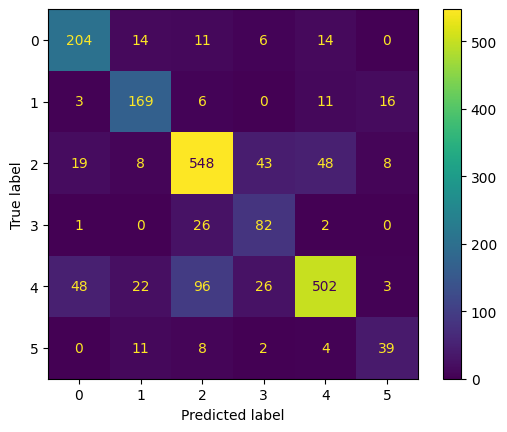

In [ ]:
data_pred_y = knn_model.predict(X_test_bow)
print("Accuracy score on testing: {:.2f}".format(accuracy_score(data_pred_y, y_test)))
print("F1 score on testing: {:.2f}".format(f1_score(data_pred_y, y_test, average = 'micro')))
cm = confusion_matrix(data_pred_y, y_test)
ConfusionMatrixDisplay(cm).plot()

Learning curve

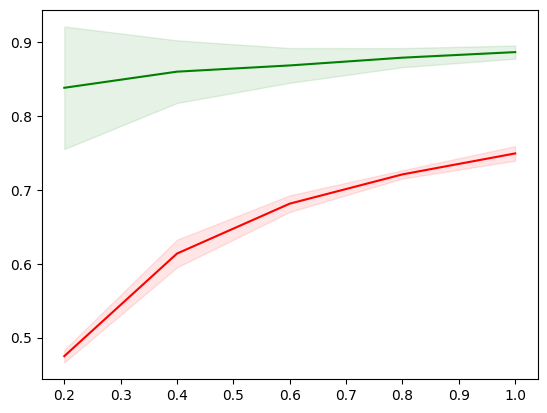

In [ ]:
train_sizes = np.linspace(0.2, 1, 5)
_, train_score, test_score = learning_curve(knn_model, X_train_bow, y_train, n_jobs = -1, cv = 5,
                                            train_sizes = train_sizes, scoring = 'accuracy')

train_mean_score = np.mean(train_score, axis = 1)
train_std_score = np.std(train_score, axis = 1)
test_mean_score = np.mean(test_score, axis = 1)
test_std_score = np.std(test_score, axis = 1)

plt.fill_between(train_sizes, train_mean_score - train_std_score, train_mean_score + train_std_score, alpha = 0.1, color = 'g')
plt.fill_between(train_sizes, test_mean_score - test_std_score, test_mean_score + test_std_score, alpha = 0.1, color = 'r')

plt.plot(train_sizes, train_mean_score, color = 'g')
plt.plot(train_sizes, test_mean_score, color = 'r')

Actually I set k = 3 to beautify the record, I ran k >= 5 and it was terrible.
Now we draw the plot for a range of k-neighbors

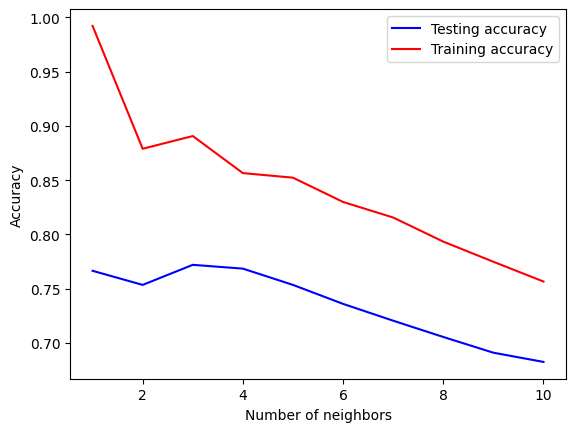

In [ ]:
# Setting the hyperparameter range
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracy_list = list()
valid_accuracy_list = list()

for k in K:
  knn_model = KNeighborsClassifier(n_neighbors = k)
  knn_model.fit(X_train_bow, y_train)

  data_pred_y = knn_model.predict(X_test_bow)
  data_valid_y = knn_model.predict(X_train_bow)

  accuracy_list.append([k, accuracy_score(y_test, data_pred_y)])
  valid_accuracy_list.append([k, accuracy_score(y_train, data_valid_y)])

accuracy_list = np.asarray(accuracy_list)
valid_accuracy_list = np.asarray(valid_accuracy_list)

plt.plot(accuracy_list[:, 0], accuracy_list[:, 1], label = "Testing accuracy", color = 'b')
plt.plot(valid_accuracy_list[:, 0], valid_accuracy_list[:, 1], label = "Training accuracy", color = 'r')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Using GridSearchCV to make a total search

In [ ]:
dict_param = {'n_neighbors': np.arange(1, 11)}
best_knn_model = GridSearchCV(KNeighborsClassifier(), param_grid = dict_param, n_jobs = -1, cv = 10, scoring = 'accuracy')

best_knn_model.fit(X_train_bow, y_train)

print("Best parameters for k_NN:", best_knn_model.best_params_)
data_best_knn_pred_y = best_knn_model.predict(X_test_bow)
print("Accuracy of that model:", accuracy_score(data_best_knn_pred_y, y_test))


Best parameters for k_NN: {'n_neighbors': 3}
Accuracy of that model: 0.772


I'm going to do just literally the same thing for TfIdf dataset... later.

## Naive Bayes classification

##Decision Tree classification


In [13]:
DT = DecisionTreeClassifier(criterion='log_loss', min_samples_leaf=5)
DT.fit(X_train_bow, y_train)

DecisionTreeClassifier(criterion='log_loss', min_samples_leaf=5)

DT accuracy = 0.88
DT f1 score = 0.88


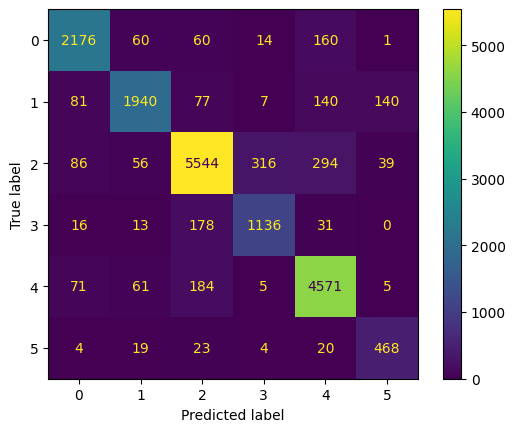

In [14]:
y_dt_pred = DT.predict(X_train_bow)
print("DT accuracy = {:.2f}".format(accuracy_score(y_dt_pred, y_train)))
print("DT f1 score = {:.2f}".format(f1_score(y_dt_pred, y_train, average = 'micro')))
cm = confusion_matrix(y_dt_pred, y_train)
ConfusionMatrixDisplay(cm).plot()

DT accuracy = 0.86
DT f1 score = 0.86


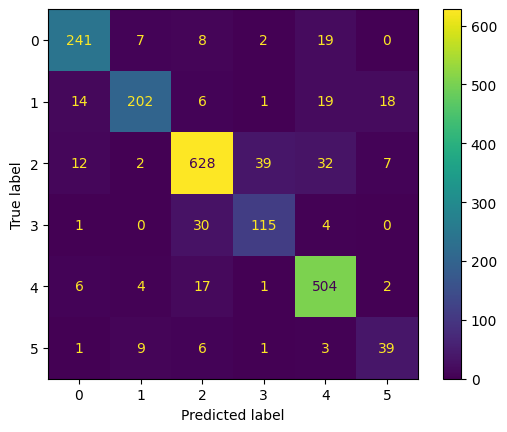

In [15]:
y_dt_pred = DT.predict(X_test_bow)
print("DT accuracy = {:.2f}".format(accuracy_score(y_dt_pred, y_test)))
print("DT f1 score = {:.2f}".format(f1_score(y_dt_pred, y_test, average = 'micro')))
cm_dt = confusion_matrix(y_dt_pred, y_test)
ConfusionMatrixDisplay(cm_dt).plot()

Learning curve

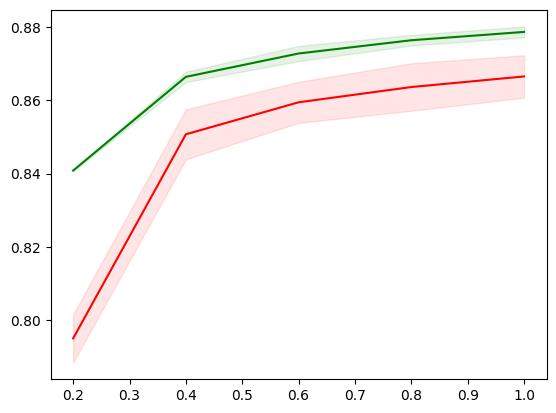

In [16]:
train_sizes = np.linspace(0.2, 1, 5)
_, train_score, test_score = learning_curve(DT, X_train_bow, y_train, n_jobs = -1, cv = 5,
                                            train_sizes = train_sizes, scoring = 'accuracy')

train_mean_score = np.mean(train_score, axis = 1)
train_std_score = np.std(train_score, axis = 1)
test_mean_score = np.mean(test_score, axis = 1)
test_std_score = np.std(test_score, axis = 1)

plt.fill_between(train_sizes, train_mean_score - train_std_score, train_mean_score + train_std_score, alpha = 0.1, color = 'g')
plt.fill_between(train_sizes, test_mean_score - test_std_score, test_mean_score + test_std_score, alpha = 0.1, color = 'r')

plt.plot(train_sizes, train_mean_score, color = 'g')
plt.plot(train_sizes, test_mean_score, color = 'r')

Draw the plot for min_samples_leaf parameter

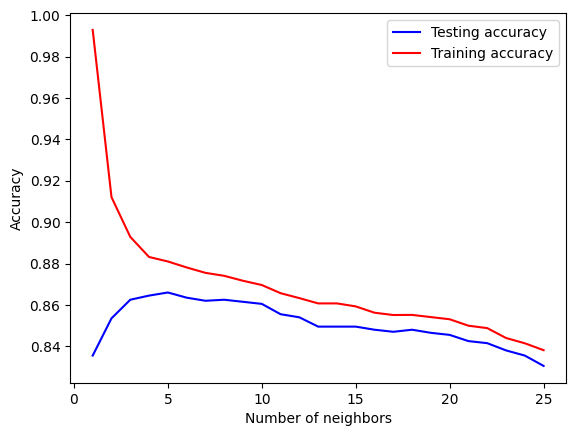

In [19]:
# Setting the min sample leaf range
K = [i for i in range(1, 26)]
accuracy_list = list()
valid_accuracy_list = list()

for k in K:
  dt_model = DecisionTreeClassifier(min_samples_leaf=k)
  dt_model.fit(X_train_bow, y_train)

  data_pred_y = dt_model.predict(X_test_bow)
  data_valid_y = dt_model.predict(X_train_bow)

  accuracy_list.append([k, accuracy_score(y_test, data_pred_y)])
  valid_accuracy_list.append([k, accuracy_score(y_train, data_valid_y)])

accuracy_list = np.asarray(accuracy_list)
valid_accuracy_list = np.asarray(valid_accuracy_list)

plt.plot(accuracy_list[:, 0], accuracy_list[:, 1], label = "Testing accuracy", color = 'b')
plt.plot(valid_accuracy_list[:, 0], valid_accuracy_list[:, 1], label = "Training accuracy", color = 'r')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Using GridSearchCV to test each parameters

In [14]:
dict_param = {'min_samples_leaf': [5, 10, 15, 20, 25]}
best_min_sample_leaf = GridSearchCV(DecisionTreeClassifier(), param_grid = dict_param, n_jobs = -1, cv = 10, scoring = 'accuracy')

best_min_sample_leaf.fit(X_train_bow, y_train)

print("Best min sample leaf parameter for decision tree:", best_min_sample_leaf.best_params_)
data_best_min_sample_leaf_y = best_min_sample_leaf.predict(X_test_bow)
print("Accuracy of that model:", accuracy_score(data_best_min_sample_leaf_y, y_test))


Best min sample leaf parameter for decision tree: {'min_samples_leaf': 5}
Accuracy of that model: 0.866


By far, the best min sample leaf parameter is 5

Draw the plot for criterion parameter

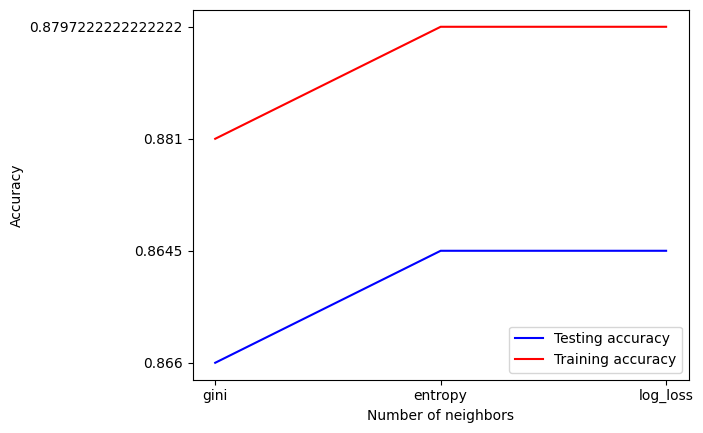

In [21]:
# Setting the min sample leaf range
K = ['gini', 'entropy', 'log_loss']
accuracy_list = list()
valid_accuracy_list = list()

for k in K:
  dt_model = DecisionTreeClassifier(criterion=k, min_samples_leaf=5)
  dt_model.fit(X_train_bow, y_train)

  data_pred_y = dt_model.predict(X_test_bow)
  data_valid_y = dt_model.predict(X_train_bow)

  accuracy_list.append([k, accuracy_score(y_test, data_pred_y)])
  valid_accuracy_list.append([k, accuracy_score(y_train, data_valid_y)])

accuracy_list = np.asarray(accuracy_list)
valid_accuracy_list = np.asarray(valid_accuracy_list)

plt.plot(accuracy_list[:, 0], accuracy_list[:, 1], label = "Testing accuracy", color = 'b')
plt.plot(valid_accuracy_list[:, 0], valid_accuracy_list[:, 1], label = "Training accuracy", color = 'r')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
dict_param = {'criterion': ['gini', 'entropy', 'log_loss']}
best_criterion = GridSearchCV(DecisionTreeClassifier(), param_grid = dict_param, n_jobs = -1, cv = 10, scoring = 'accuracy')

best_criterion.fit(X_train_bow, y_train)

print("Best criterion parameter for decision tree:", best_criterion.best_params_)
data_best_criterion_y = best_criterion.predict(X_test_bow)
print("Accuracy of that model:", accuracy_score(data_best_criterion_y, y_test))

Best criterion parameter for decision tree: {'criterion': 'log_loss'}
Accuracy of that model: 0.8435


In [12]:
dict_param = {'max_leaf_nodes': np.arange(10, 51, 10)}
best_max_leaf_nodes = GridSearchCV(DecisionTreeClassifier(), param_grid = dict_param, n_jobs = -1, cv = 10, scoring = 'accuracy')

best_max_leaf_nodes.fit(X_train_bow, y_train)

print("Best max leaf nodes parameter for decision tree:", best_max_leaf_nodes.best_params_)
data_best_max_leaf_nodes_y = best_max_leaf_nodes.predict(X_test_bow)
print("Accuracy of that model:", accuracy_score(data_best_max_leaf_nodes_y, y_test))

Best max leaf nodes parameter for decision tree: {'max_leaf_nodes': 50}
Accuracy of that model: 0.4845


##Random Forest

In [ ]:
RF = RandomForestClassifier()
RF.fit(X_train_bow, y_train)

RandomForestClassifier()

RF accuracy = 0.99
RF f1 score = 0.99


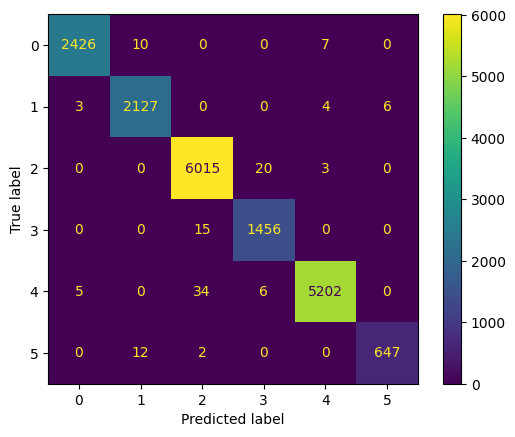

In [ ]:
y_rf_pred = RF.predict(X_train_bow)
print("RF accuracy = {:.2f}".format(accuracy_score(y_rf_pred, y_train)))
print("RF f1 score = {:.2f}".format(f1_score(y_rf_pred, y_train, average = 'micro')))
cm = confusion_matrix(y_rf_pred, y_train)
ConfusionMatrixDisplay(cm).plot()

RF accuracy = 0.87
RF f1 score = 0.87


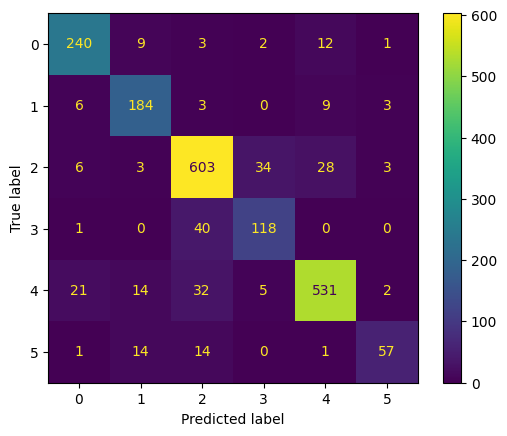

In [ ]:
y_rf_pred = RF.predict(X_test_bow)
print("RF accuracy = {:.2f}".format(accuracy_score(y_rf_pred, y_test)))
print("RF f1 score = {:.2f}".format(f1_score(y_rf_pred, y_test, average = 'micro')))
cm_rf = confusion_matrix(y_rf_pred, y_test)
ConfusionMatrixDisplay(cm_rf).plot()

# **Conclusion**